!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!pip -q install torch-spline-conv==latest+cu102 torch-scatter==latest+cu102 torch-cluster==latest+cu102 torch-sparse==latest+cu102  -f https://pytorch-geometric.com/whl/torch-1.6.0.html

!pip install -q git+https://github.com/elmahyai/pytorch_geometric_temporal   # remove after merging

<h1>
<center>Attention Based Spatial-Temporal Graph Convolutional Networks
for Traffic Flow Forecasting</center>
</h1>

In this notebook we will dive into attentional temporal graph convolution networks where everything new meets Attention + deep learning time series analysis( temporal data) + Graph convolution all in one thing. This is a rewriting of the code of the paper (Attention Based Spatial-Temporal Graph Convolutional Networks for Traffic Flow Forecasting https://ojs.aaai.org/index.php/AAAI/article/view/3881 ), from which we will include quotes and parts of their code. This notebook uses the data prepared in the previous notebook (Processing traffic data for deep learning projects)

In [7]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.sparse.linalg import eigs


USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')
print("CUDA:", USE_CUDA, DEVICE)

from tensorboardX import SummaryWriter
sw = SummaryWriter(logdir='./Teacher', flush_secs=5)

import math
from typing import Optional, List, Union

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.typing import OptTensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.transforms import LaplacianLambdaMax
from torch_geometric.utils import remove_self_loops, add_self_loops, get_laplacian
from torch_geometric.utils import to_dense_adj
from torch_scatter import scatter_add

CUDA: True cuda:0


# Loading data  ( The temporal part) 
As discussed in the previous notebook, the data is splitted as follows:

10181 data/target examples will be used as the training set ( 35 days )

3394 data/target examples will be used as the validation set (12 days)

3394 data/target examples will be used as the testing set (12 days)

The shape for each prediction / target hour example is  (12, 307, 3)  , As the data will be loaded in batches of size 32 

data, edge hour

its shape will be (32, 12, 307, 3)

In [8]:
def load_graphdata_channel1(graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, batch_size,
                            shuffle=True, DEVICE = torch.device('cuda:0')):
    '''
    :param graph_signal_matrix_filename: str
    :param num_of_hours: int
    :param num_of_days: int
    :param num_of_weeks: int
    :param DEVICE:
    :param batch_size: int
    :return:
    three DataLoaders, each dataloader contains:
    test_x_tensor: (B, N_nodes, in_feature, T_input)
    test_decoder_input_tensor: (B, N_nodes, T_output)
    test_target_tensor: (B, N_nodes, T_output)
    '''

    file = os.path.basename(graph_signal_matrix_filename).split('.')[0]
    filename = os.path.join('./data/PEMS04/', file + '_r' + str(num_of_hours) + '_d' + str(num_of_days) + '_w' + str(num_of_weeks)) +'_astcgn'
    print('load file:', filename)

    file_data = np.load(filename + '.npz')
    train_x = file_data['train_x']  # (10181, 307, 3, 12)
    train_x = train_x[:, :, 0:1, :]
    train_target = file_data['train_target']  # (10181, 307, 12)

    val_x = file_data['val_x']
    val_x = val_x[:, :, 0:1, :]
    val_target = file_data['val_target']

    test_x = file_data['test_x']
    test_x = test_x[:, :, 0:1, :]
    test_target = file_data['test_target']

    mean = file_data['mean'][:, :, 0:1, :]  # (1, 1, 3, 1)
    std = file_data['std'][:, :, 0:1, :]  # (1, 1, 3, 1)

    # ------- train_loader -------
    train_x_tensor = torch.from_numpy(train_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    # ------- val_loader -------
    val_x_tensor = torch.from_numpy(val_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    val_target_tensor = torch.from_numpy(val_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    val_dataset = torch.utils.data.TensorDataset(val_x_tensor, val_target_tensor)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # ------- test_loader -------
    test_x_tensor = torch.from_numpy(test_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    test_dataset = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # print
    print('train:', train_x_tensor.size(), train_target_tensor.size())
    print('val:', val_x_tensor.size(), val_target_tensor.size())
    print('test:', test_x_tensor.size(), test_target_tensor.size())

    return train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, mean, std


In [9]:
graph_signal_matrix_filename = './data/PEMS04/pems04.npz'
batch_size = 16
num_of_weeks = 1
num_of_days = 1
num_of_hours = 1

train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, _mean, _std = load_graphdata_channel1(
    graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, batch_size)

load file: ./data/PEMS04/pems04_r1_d1_w1_astcgn
train: torch.Size([13575, 307, 1, 12]) torch.Size([13575, 307, 12])
val: torch.Size([1697, 307, 1, 12]) torch.Size([1697, 307, 12])
test: torch.Size([1697, 307, 1, 12]) torch.Size([1697, 307, 12])


# Loading the graph ( The spatial part) 

In our case the graph is the Traffic Networks (literally, the network between the detectors (sensors) applied on the traffic networks

In our example we have 307 detectors that when connected spatially, give our traffic network under investigation.


In [14]:
def get_adjacency_matrix(distance_df_filename, num_of_vertices, id_filename=None):
    '''
    Parameters
    ----------
    distance_df_filename: str, path of the csv file contains edges information
    num_of_vertices: int, the number of vertices
    Returns
    ----------
    A: np.ndarray, adjacency matrix
    '''
    if 'npy' in distance_df_filename:  # false
        adj_mx = np.load(distance_df_filename)
        return adj_mx, None
    else:
        
        #--------------------------------------------- read from here
        import csv
        A = np.zeros((int(num_of_vertices), int(num_of_vertices)),dtype=np.float32)
        distaneA = np.zeros((int(num_of_vertices), int(num_of_vertices)), dtype=np.float32)

        
        if id_filename: 
            with open(id_filename, 'r') as f:
                id_dict = {int(i): idx for idx, i in enumerate(f.read().strip().split('\n'))}  # 把节点id（idx）映射成从0开始的索引

            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[id_dict[i], id_dict[j]] = 1
                    distaneA[id_dict[i], id_dict[j]] = distance
            return A, distaneA

        else:
         #-------------Continue reading
            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[i, j] = 1
                    distaneA[i, j] = distance
            return A, distaneA

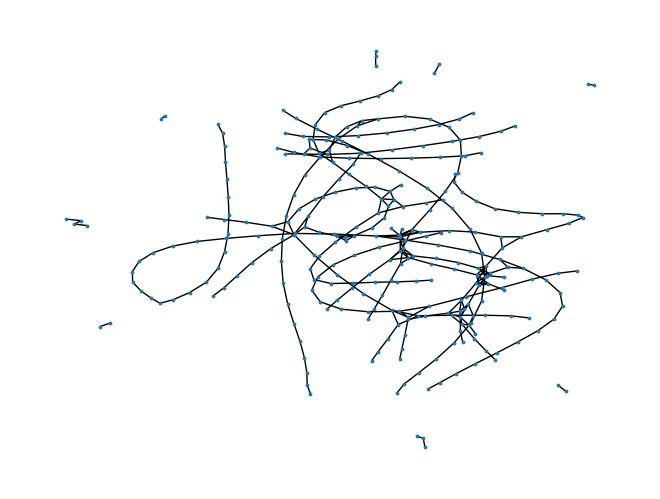

In [15]:
id_filename = None
adj_filename = './data/PEMS04/PEMS04.csv'
num_of_vertices = 307
adj_mx, distance_mx = get_adjacency_matrix(adj_filename, num_of_vertices, id_filename) #  adj_mx and distance_mx (307, 307)
rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=3)
plt.show()
rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
edge_index_data = torch.LongTensor(np.array([rows, cols])).to(DEVICE)

# Making the model

# Model Layers

## Temporal attention layer

In the temporal dimension, there exist correlations between the traffic conditions in different time slices, and the correlations are also varying under different situations. Likewise, we use an attention mechanism to adaptively attach different importance to data. 

<img src="https://i.ibb.co/KwXCqJx/temp-attention.png" width="400">



To understand the equation :

It learns to attend (focus) on which part of the time segement used as input. In our case we have 12 time points So it will generate 12 by 12 weights. 

<img src="https://i.ibb.co/NZ4fh4k/atten2.jpg" width="400">

## Spatial attention layer

In the spatial dimension, the traffic conditions of different locations have influence among each other and the mutual influence is highly dynamic. Here, we use an attention mechanism (Feng et al. 2017) to adaptively capture the dynamic correlations between nodes in the spatial dimension.

<img src="https://i.ibb.co/PGnj4MR/spatial1.png" width="400">

<img src="https://i.ibb.co/G5jkKvr/spatial2.png" width="400">


The same as with the temporal attention; however, here the attention weights will be used inside a Graph convolution layer



<img src="https://i.ibb.co/stTfTFM/spat2.jpg" width="400">


## Spectral graph analysis on the spatial part
Since the spatial part is represented as a graph, we will apply graph convolution to aggregate messages from neighbor nodes. The type of graph convolution that we are going to use is spectral convolution. 

* In spectral graph analysis, a graph is represented by its corresponding Laplacian matrix. 
* The properties of the graph structure can be obtained by analyzing Laplacian matrix and its eigenvalues

* Laplacian matrix of a graph is defined as L = D − A, 

* Its normalized form is L = I − ((1/ sqrt(D) A ( 1/ sqrt(D))  

where A is the adjacent matrix, I is a unit matrix, and the degree matrix D (diagnoal diagonal matrix, consisting of node degrees,at the diagonal) 

The eigenvalue decomposition of the Laplacian matrix is L = U*Λ*(U.transpose()) , where Λ = diag([λ0, ..., λN −1]) is a diagonal matrix, and U is Fourier basis. 

U is an orthogonal matrix.

The graph convolution is a convolution operation implemented by using linear operators that diagonalize in the Fourier domain to replace the classical convolution operator.

However, it is expensive to directly perform the eigenvalue decomposition on the Laplacian matrix when the scale of the graph is large. Therefore, Chebyshev polynomials are adopted to solve this problem approximately but efficiently. 






# The ASTGCN model structure


The model is composed of two ASTGCN blocks followed by a final layer

Original x (input) is (32, 307, 1, 12) -Block1> (32, 307, 64, 12) -Block2> (32, 307, 64, 12) -permute-> (32, 12, 307,64) 
            # -final_conv-> (32, 12, 307, 1) -reshape-> (32,307,12) "The target"
            


The model is  the fusion of three independent components with the same structure, which are designed to respectively model the recent, daily-periodic and weekly-periodic dependencies of the historical data. This is discussed in the previous notebook (https://www.kaggle.com/elmahy/processing-traffic-data-for-deep-learning-projects). 

 

![astgcn.png](attachment:ec80c00c-6836-4449-85ba-e0b9d174a2f5.png)

In [7]:
from model.ASTGCN import ASTGCN

In [8]:
# from torch_geometric_temporal.nn.attention import ASTGCN   # For information about the architecture check the source code

# Initialized the ASTGCN model


In [9]:
nb_block = 2
in_channels = 1
K = 3
nb_chev_filter = 64
nb_time_filter = 64
time_strides = num_of_hours
num_for_predict = 12
len_input = 12
dropout=0.01
#dropout posibilty
#L_tilde = scaled_Laplacian(adj_mx)
#cheb_polynomials = [torch.from_numpy(i).type(torch.FloatTensor).to(DEVICE) for i in cheb_polynomial(L_tilde, K)]
# net = ASTGCN( nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input, num_of_vertices).to(DEVICE)

Teacher= ASTGCN(nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input, num_of_vertices,dropout).to(DEVICE)
print(Teacher)



ASTGCN(
  (_blocklist): ModuleList(
    (0): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(1, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (_dropout): Dropout2d(p=0.01, inplace=True)
    )
    (1): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(64, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (_dropout): 

## initialized teacher model

In [10]:
#------------------------------------------------------
# 
optimizerTeacher = optim.Adam(Teacher.parameters(), lr=1e-3,weight_decay=1e-6)#l2 regularization applied in weightdecay<0

print('Teacher\'s state_dict:')
total_param = 0
for param_tensor in Teacher.state_dict():
    print(param_tensor, '\t', Teacher.state_dict()[param_tensor].size(), '\t', Teacher.state_dict()[param_tensor].device)
    total_param += np.prod(Teacher.state_dict()[param_tensor].size())
print('Teacher\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizerTeacher.state_dict():
    print(var_name, '\t', optimizerTeacher.state_dict()[var_name])


Teacher's state_dict:
_blocklist.0._temporal_attention._U1 	 torch.Size([307]) 	 cuda:0
_blocklist.0._temporal_attention._U2 	 torch.Size([1, 307]) 	 cuda:0
_blocklist.0._temporal_attention._U3 	 torch.Size([1]) 	 cuda:0
_blocklist.0._temporal_attention._be 	 torch.Size([1, 12, 12]) 	 cuda:0
_blocklist.0._temporal_attention._Ve 	 torch.Size([12, 12]) 	 cuda:0
_blocklist.0._spatial_attention._W1 	 torch.Size([12]) 	 cuda:0
_blocklist.0._spatial_attention._W2 	 torch.Size([1, 12]) 	 cuda:0
_blocklist.0._spatial_attention._W3 	 torch.Size([1]) 	 cuda:0
_blocklist.0._spatial_attention._bs 	 torch.Size([1, 307, 307]) 	 cuda:0
_blocklist.0._spatial_attention._Vs 	 torch.Size([307, 307]) 	 cuda:0
_blocklist.0._chebconv_attention._weight 	 torch.Size([3, 1, 64]) 	 cuda:0
_blocklist.0._chebconv_attention._bias 	 torch.Size([64]) 	 cuda:0
_blocklist.0._time_convolution.weight 	 torch.Size([64, 64, 1, 3]) 	 cuda:0
_blocklist.0._time_convolution.bias 	 torch.Size([64]) 	 cuda:0
_blocklist.0._resid

# Defining the loss function

 1. masked_mae

In [11]:
def masked_mae(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels != null_val)
    mask = mask.float()
    mask /= torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(preds - labels)
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)


In [12]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,ytil,y):
        return torch.sqrt(self.mse(ytil,y))

In [13]:
criterionTeacher=RMSELoss().to(DEVICE)
criterion_masked = masked_mae
loss_function='mae'

metric_method = 'mask'
missing_value=0.0

if loss_function=='masked_mse':
    criterion_masked = masked_mse         #nn.MSELoss().to(DEVICE)
    masked_flag=1
elif loss_function=='masked_mae':
    criterion_masked = masked_mae
    masked_flag = 1
elif loss_function == 'mae':
    criterion = nn.L1Loss().to(DEVICE)
    masked_flag = 0
elif loss_function == 'rmse':
    criterion = nn.MSELoss().to(DEVICE)
    masked_flag= 0

In [14]:
ValLoss=[]
TrainLoss=[]

In [15]:
def compute_val_loss_mstgcn(net, val_loader, criterion,  masked_flag,missing_value,sw, epoch, edge_index_data, limit=None):
    '''
    for rnn, compute mean loss on validation set
    :param net: model
    :param val_loader: torch.utils.data.utils.DataLoader
    :param criterion: torch.nn.MSELoss
    :param sw: tensorboardX.SummaryWriter
    :param global_step: int, current global_step
    :param limit: int,
    :return: val_loss
    '''
    net.train(False)  # ensure dropout layers are in evaluation mode
    with torch.no_grad():
        val_loader_length = len(val_loader)  # nb of batch
        tmp = []  # batch loss
        for batch_index, batch_data in enumerate(val_loader):
            encoder_inputs, labels = batch_data
            outputs = net(encoder_inputs, edge_index_data)
            if masked_flag:
                loss = criterion(outputs, labels)
            else:
                loss = criterion(outputs, labels)
            tmp.append(loss.item())
            if batch_index % 20 == 0:
                print('validation batch %s / %s, loss: %.2f' % (batch_index + 1, val_loader_length, loss.item()))
            if (limit is not None) and batch_index >= limit:
                break

        validation_loss = sum(tmp) / len(tmp)
        sw.add_scalar('validation_loss', validation_loss, epoch)
        ValLoss.append(validation_loss)
        print("rata rata val_loss",validation_loss,"pada epoch:",epoch)
    return validation_loss

In [16]:
global_step = 0
best_epoch = 0
best_val_loss = np.inf
start_time= time()
masked_flag = 0

In [ ]:
# pretrain model teacher
maxi=[]
for epoch in range(40):
    params_filename = os.path.join('./Teacher/', 'checkpoint_%s.pth' %epoch)
    tmp=[]
    Teacher.train()  # ensure dropout layers are in train mode
    for batch_index, batch_data in enumerate(train_loader):
        encoder_inputs, labels = batch_data   # encoder_inputs torch.Size([32, 307, 1, 12])  label torch.Size([32, 307, 12])
        optimizerTeacher.zero_grad()
        outputs = Teacher(encoder_inputs, edge_index_data) # torch.Size([32, 307, 12])
        loss = criterionTeacher(outputs, labels)
        loss.backward()
        optimizerTeacher.step()
        training_loss = loss.item()
        tmp.append(training_loss)
        global_step += 1
        maxi.append(training_loss)
        sw.add_scalar('training_loss', training_loss, global_step)
        if global_step % 100 == 0:
            print('global step: %s, training loss: %.2f, time: %.2fs' % (global_step, training_loss, time() - start_time))
    rtloss_t=sum(tmp) / len(tmp)
    TrainLoss.append(rtloss_t)
    print("rata rata Trainingloss",rtloss_t,"pada epoch:",epoch)
    val_loss = compute_val_loss_mstgcn(Teacher, val_loader, criterionTeacher, masked_flag, missing_value, sw, epoch,edge_index_data)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        checkpoint = {
            'epoch': best_epoch,
            'model_state': Teacher.state_dict(),
            'optimizer_state': optimizerTeacher.state_dict()
        }
        torch.save(checkpoint, params_filename)
        
        print('save parameters to file: %s' % params_filename)
    
          
    
print('best epoch:', best_epoch)
path=os.path.join("./Teacher/",'losshistval.npy')
path1=os.path.join("./Teacher/",'losshisttrain.npy')
np.save(path,ValLoss)
np.save(path1,TrainLoss)
n=max(maxi)-min(maxi)
print(n)
np.save('./Teacher/N',n)

In [ ]:
epoch=39
params_filename = os.path.join('./Teacher/', 'checkpoint_%s.pth' %epoch)
checkpoint = {
            'epoch': epoch,
            'model_state': Teacher.state_dict(),
            'optimizer_state': optimizerTeacher.state_dict()
        }
torch.save(checkpoint, params_filename)

In [ ]:
print(best_epoch)
print(best_val_loss)

In [ ]:
epoch =  13
params_filename = os.path.join('./Teacher/', 'checkpoint_%s.pth' % epoch)
loaded_checkpoint=torch.load(params_filename)
epoch=loaded_checkpoint['epoch']
Teacher.load_state_dict(loaded_checkpoint['model_state'])
optimizerTeacher.load_state_dict(loaded_checkpoint['optimizer_state'])
Teacher.eval()

In [ ]:
print(Teacher.state_dict())

In [ ]:
for var_name in optimizerTeacher.state_dict():
    print(var_name, "\t", optimizerTeacher.state_dict()[var_name])

In [ ]:
from time import process_time as ps
start = ps() 
Teacher.train(False)  # ensure dropout layers are in evaluation mode
with torch.no_grad():
    test_loader_length = len(test_loader)  # nb of batch
    tmp = []  # batch loss
    for batch_index, batch_data in enumerate(test_loader):
        encoder_inputs, labels = batch_data
        outputs = Teacher(encoder_inputs, edge_index_data)
        loss = criterionTeacher(outputs, labels)
        tmp.append(loss.item())
        if batch_index % 1 == 0:
            print('test_loss batch %s / %s, loss: %.2f ' % (batch_index + 1, test_loader_length, loss.item()))

    
    test_loss = sum(tmp) / len(tmp)
end = ps()
print(" waktu komputasi : ",end-start, "second" + " loss: ", test_loss)  
    
# print(test_loss)

In [ ]:
sample_output = outputs[0]  # prediction
sample_labels = labels[0] # truth
print(sample_output.shape, sample_labels.shape)

In [ ]:
from torchmetrics import MeanAbsolutePercentageError as Mape
mape=Mape().to(DEVICE)

In [ ]:
a=0
Teacher.train(False)  # ensure dropout layers are in evaluation mode
with torch.no_grad():
    test_loader_length = len(test_loader)  # nb of
    for batch_index, batch_data in enumerate(test_loader):
        if accuracy1==accuracy2:
            a.sum(1)
        else:
            a
a/test_loader_length    


In [ ]:
fig, ax = plt.subplots(figsize=(30,20),dpi=60)

for i in range(1):
    new_i = i * 12
    plt.plot(range(0+new_i,12+new_i),sample_labels[i].cpu().numpy(), color='blue')
    plt.plot(range(0+new_i,12+new_i),sample_output[i].detach().cpu().numpy(), color = 'red')
fig.suptitle('Kepadatan Lalu lintas pada detektor No.40030 ', fontsize=20)
plt.xlabel('Jam', fontsize=18)
plt.ylabel('Kepadatan', fontsize=16)
fig.savefig("10pred.png")

In [ ]:
total_params = sum(
	param.numel() for param in Teacher.parameters()
)
total_params

# Pickig a random time point and visualizing the predictions of the first 50 detectors

In [ ]:
sample_output = outputs[0]  # prediction
sample_labels = labels[0] # truth
print(sample_output.shape, sample_labels.shape)

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(3,4), dpi=80)
for i in range(50):
    new_i = i * 12
    plt.plot(range(0+new_i,12+new_i),sample_output[i].detach().cpu().numpy(), color = 'red')
    plt.plot(range(0+new_i,12+new_i),sample_labels[i].cpu().numpy(), color='blue')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(80,6),dpi=80)

for i in range(50):
    new_i = i * 12
    plt.plot(range(0+new_i,12+new_i),sample_output[i].detach().cpu().numpy(), color = 'red')
    plt.plot(range(0+new_i,12+new_i),sample_labels[i].cpu().numpy(), color='blue')
ax.set(title="prediction and target",xlabel="location id",ylabel="pediction")
fig.savefig("10pred.png")

 # test_x_tensor: (B, N_nodes, in_feature, T_input)

In [ ]:
for batch_index, batch_data in enumerate(train_loader):
        encoder_inputs, labels = batch_data
        print(encoder_inputs[0])
        print(labels[0])

In [ ]:
encoder_inputs[0].size()

In [ ]:
encoder_inputs[:1,:4,0]

In [ ]:
edge_index_data.size()

In [ ]:
edge_index_data.size()

In [ ]:
labels[0,0]